# Working with the Hipparcos Intermediate Astrometric Data (IAD)

Sarah Blunt (2021)

The Hipparcos IAD are notoriously annoying to work with, and several methods have been developed for incorporating them 
into orbit-fits. In this tutorial, we'll take you through the method outlined in [Nielsen et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020AJ....159...71N/abstract). In the near future, we'll add in other algorithms (in particular, that of [Brandt et al.](https://ui.adsabs.harvard.edu/abs/2021ApJS..254...42B/abstract)). 

The purpose of this tutorial is not to convince you that one method is better than the other, but rather to teach you to use the method of
Nielsen et al. I recommend reading through Section 3.1 of Nielsen et al. (2020) before diving into this tutorial. Note that this tutorial only fits for the Hipparcos astrometry, and does not also consider Gaia astrometry. Both are needed to fully reproduce the dynamical mass estimates from Nielsen et al. (2020). 

If you want to skip right to "what's the syntax for doing an orbit-fit with the IAD," I suggest checking out the beta Pictoris end-to-end test I coded up [here](https://github.com/sblunt/orbitize/blob/develop/tests/end-to-end-tests/betaPic_hipIAD.py).

This tutorial will take you through:
- Obtaining the IAD for your object(s).
- Refitting the IAD (i.e. re-doing the fit the Hipparcos team did), which allows you to evaluate whether they are 
suitable for orbit-fitting.
- Incorporating the IAD into your orbit-fit.

## Part 1: Obtaining the IAD

`orbitize!` assumes the IAD are an updated version of the [van Leeuwen (2007) re-reduction](https://ui.adsabs.harvard.edu/abs/2007ASSL..350.....V/abstract). You can learn about the data [here](https://www.cosmos.esa.int/web/hipparcos/hipparcos-2), and download them [here](https://www.cosmos.esa.int/documents/532822/6470227/ResRec_JavaTool_2014.zip/a58ad12e-cffb-f959-0ed5-2ae26899f61a?t=1631109433177&download=true). Note that this download will take ~350 MB of space; if you prefer to to keep the data necessary for a few fits, you can download all the data and remove unnecessary files (or just [send me an email](https://sites.google.com/g.harvard.edu/sarah/contact)).
We've provided the IAD files for a few representative systems in this repository.

NOTE: if you prefer to use the DVD files, `orbitize!` can handle those as well. However, be warned that these files do not mark rejected scans.

The good news is that the hard part is actually getting the data. Once you have the file, `orbitize!` can read it in its raw form.

## Part 2: Refitting the IAD

Once you have the IAD, the next step is to convince yourself that they're suitable for orbit-fitting (i.e. free of transcription errors, etc).
Here's a handy function to do this (this should take a few mins to run, but if it's taking much longer, you can decrease the number of steps). This code reproduces the test at the end of Section 3.1 of Nielsen et al. (2020), so check that out for more information.

Go get a coffee. This will take a few mins! :)
Starting burn-in!
Starting production chain!
Done! This fit took 4.9 mins on my machine.


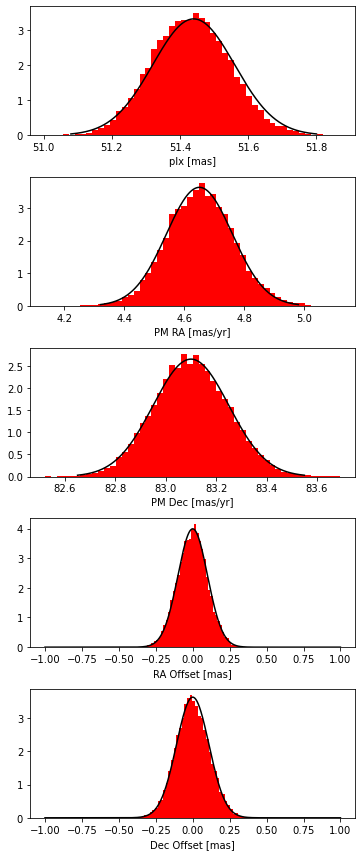

In [2]:
import orbitize
import os
from datetime import datetime

from orbitize.hipparcos import nielsen_iad_refitting_test

# The Hipparcos ID of your target. Available on Simbad.
hip_num = '027321'  

# Name/path for the plot this function will make         
saveplot = 'bPic_IADrefit.png'   

# Location of the Hipparcos IAD file.
IAD_file = '{}H{}.d'.format(orbitize.DATADIR, hip_num)   

# These `emcee` settings are sufficient for the 5-parameter fits we're about to run,
#   although I'd probably run it for 5,000-10,000 steps if I wanted to publish it.
burn_steps = 100                
mcmc_steps = 500                 

start = datetime.now()

# run the fit
print('Go get a coffee. This will take a few mins! :)')
nielsen_iad_refitting_test(
    IAD_file,
    hip_num=hip_num, 
    saveplot=saveplot, 
    burn_steps=burn_steps, 
    mcmc_steps=mcmc_steps
)

end = datetime.now()
duration_mins = (end - start).total_seconds() / 60

print("Done! This fit took {:.1f} mins on my machine.".format(duration_mins))

# If you don't want to save the plot, you can run this line to remove it
_ = os.system('rm {}'.format(saveplot))

## Part 3: Using the IAD in your Orbit-fit

Congrats, you've now reproduced a Hipparcos fit! The last thing to do is actually run your orbit-fit. Here's an example. This code snippet essentially repeats the beta Pictoris end-to-end test I coded up [here](https://github.com/sblunt/orbitize/blob/develop/tests/end-to-end-tests/betaPic_hipIAD.py).

In [3]:
import os.path
import orbitize
from orbitize import read_input, hipparcos, system, priors, sampler

"""
As with most `orbitize!` fits, we'll start by reading in our data file. The 
Hipparcos data file is kept separate; your main data file only needs to contain 
the relative astrometry and RVs you're using in your fit.
"""

input_file = os.path.join(orbitize.DATADIR, 'betaPic.csv')
data_table = read_input.read_file(input_file)

"""
Next, we'll instantiate a `HipparcosLogProb` object.
"""
num_secondary_bodies = 1  # number of planets/companions orbiting your primary
hipparcos_number='027321' # (can look up your object's Hipparcos ID on Simbad)
hipparcos_filename=os.path.join(orbitize.DATADIR, 'H027321.d') # location of your IAD data file

betaPic_Hip = hipparcos.HipparcosLogProb(
    hipparcos_filename, hipparcos_number, num_secondary_bodies
)

"""
Next, we'll instantiate a `System` object, a container for all the information
relevant to the system you're fitting. 
"""

m0 = 1.75                 # [M_sol]
plx = 51.5                # [mas]
fit_secondary_mass = True # Tell orbitize! we want to get dynamical masses 
                          #  (not possible with only relative astrometry).
mass_err = 0.01           # we'll overwrite these in a sec
plx_err = 0.01

betaPic_system = system.System(
    num_secondary_bodies, data_table, m0, plx, hipparcos_IAD=betaPic_Hip, 
    fit_secondary_mass=fit_secondary_mass, mass_err=mass_err, plx_err=plx_err
)

"""
If you'd like to change any priors from the defaults (given in Blunt et al. 2020),
do it like this:
"""

# set uniform parallax prior
plx_index = betaPic_system.param_idx['plx']
betaPic_system.sys_priors[plx_index] = priors.UniformPrior(plx - 1.0, plx + 1.0)

# set uniform primary mass prior
m0_index = betaPic_system.param_idx['m0']
betaPic_system.sys_priors[m0_index] = priors.UniformPrior(1.5, 2.0)

Finally, set up and run your MCMC!

In [4]:
"""
These are the MCMC parameters I'd use if I were publishing this fit. 
This would take a while to run (takes about a day on my machine). 
"""
# num_threads = 50
# num_temps = 20
# num_walkers = 1000
# num_steps = 10000000 # n_walkers x n_steps_per_walker
# burn_steps = 10000
# thin = 100

"""
Here are some parameters you can use for the tutorial. These chains will not 
be converged.
"""

num_threads = 1
num_temps = 1
num_walkers = 100
num_steps = 10 # n_walkers x n_steps_per_walker
burn_steps = 10
thin = 1

betaPic_sampler = sampler.MCMC(
    betaPic_system, num_threads=num_threads, num_temps=num_temps, 
    num_walkers=num_walkers
)
betaPic_sampler.run_sampler(num_steps, burn_steps=burn_steps, thin=thin)

Starting Burn in


/home/sblunt/Projects/orbitize/orbitize/priors.py:351: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sblunt/Projects/orbitize/orbitize/priors.py:460: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


10/10 steps of burn-in complete
Burn in complete. Sampling posterior now.

Run complete


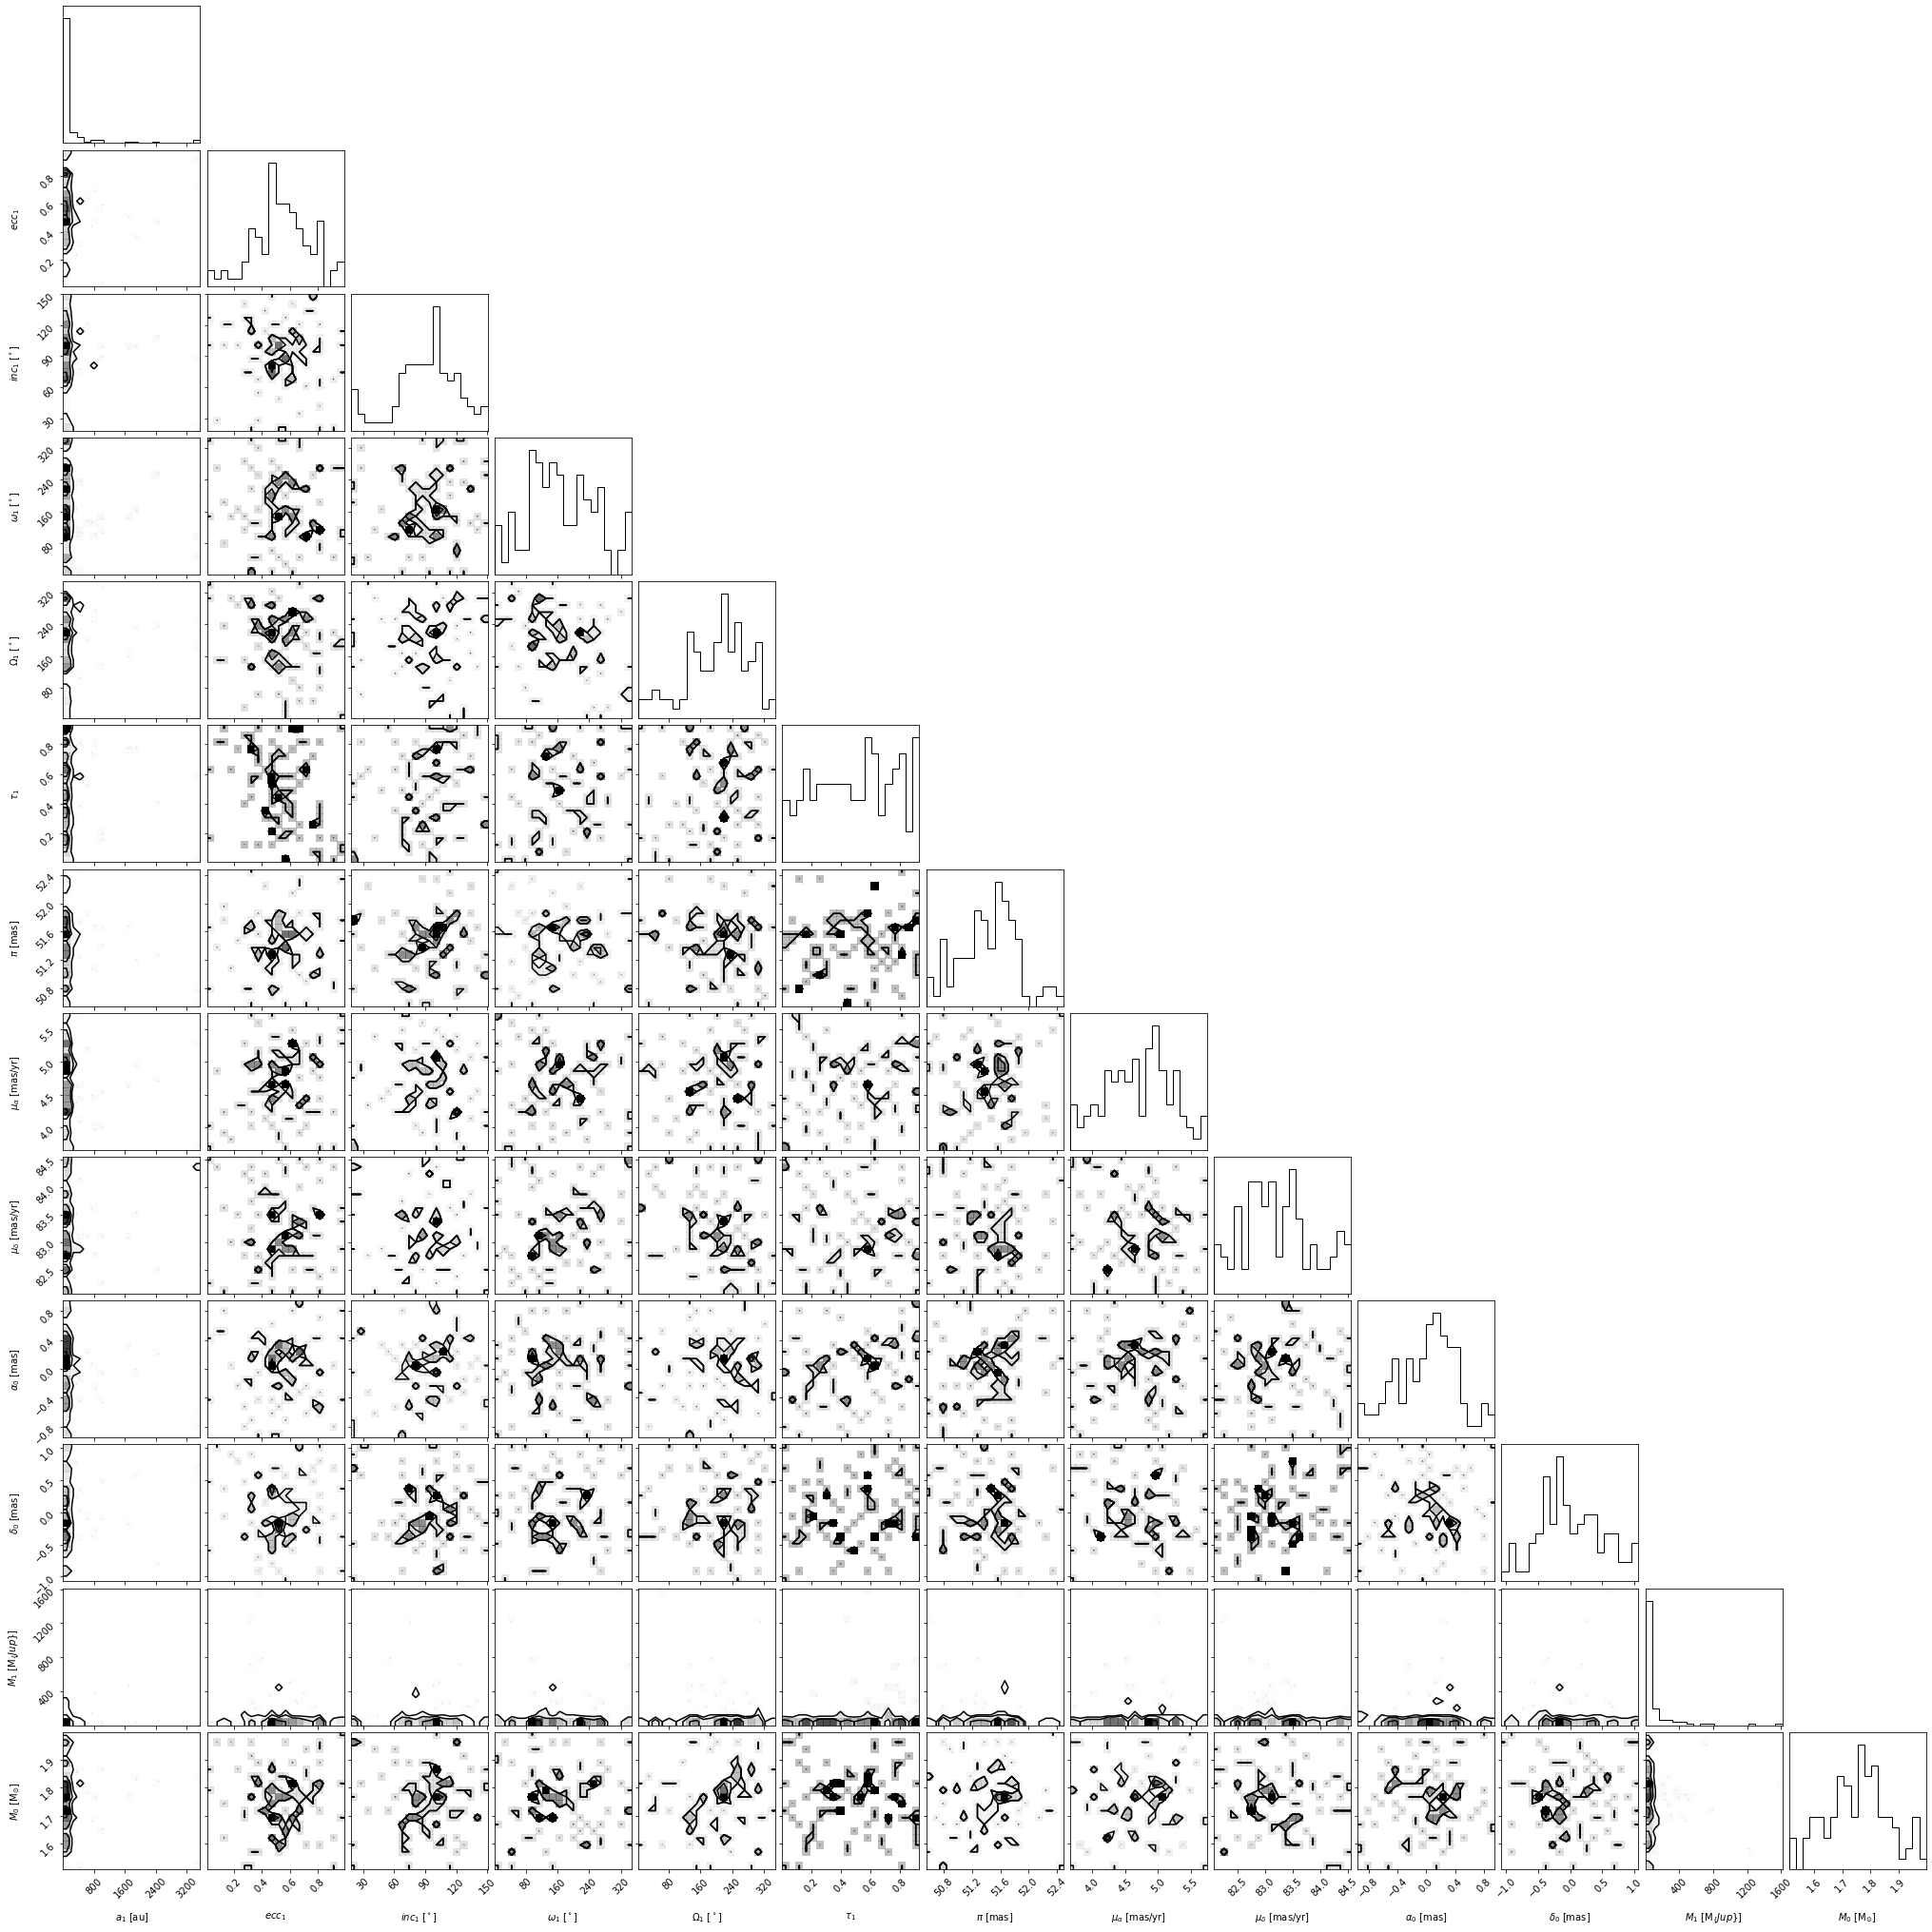

In [5]:
# make corner plot
fig = betaPic_sampler.results.plot_corner()